In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset, Subset
# from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [2]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [3]:
# directory setup cell
repo = 'tree-finder/'
location = 'aws'
save_mode = False

# Local paths
local_root = '/Users/etriesch/dev/'
colab_root = '/content/drive/My Drive/git/'
aws_root = '/home/ec2-user/'

# define root
if location == 'local':
  root = local_root
elif location == 'google':
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  root = colab_root
elif location == 'aws':
  root = aws_root

repo_path = root + repo
model_path = repo_path + 'models/'
data_path = repo_path + 'data/'
results_path = repo_path + 'results/'
sys.path.append(repo_path)

In [4]:
# setup cell
from notebooks.viz_fns import show_image_batch, set_plt_settings
from notebooks.viz_fns import plot_accs
from notebooks.train_fns import Flatten, train_model
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetTransferClassifier, ConvnextTransferClassifier, TransformerTransferClassifier
from notebooks.scrape_fns import get_filelist

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [5]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=[10,25,50])
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path + 'images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [6]:
# load image scores
filename = 'images_spec_realtree_pcts.csv'
realtree_likelihood = np.loadtxt(data_path + filename).astype(float).tolist()

# subset based on threshold
threshold=0.85
flag = np.array(realtree_likelihood) > threshold
realtree_idxs = (np.arange(0, len(flag))[flag]).tolist()
print(f'\nimages meeting threshold ({threshold}): {sum(flag)} ({sum(flag)/len(flag):0.2%})')
# realtree_idxs = None

# make dataloaders with the subset data
dataloaders, ds_sizes = make_dataloaders(
    dataset=treeds, subset=realtree_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=32, seed=1)


images meeting threshold (0.85): 24944 (75.97%)
dataloader sizes: {'all': 24944, 'train': 16836, 'validate': 5613, 'test': 2495, 'sampler': 4}


# Baseline models

In [9]:
# define small loader for testing
random_idxs = np.random.choice(range(len(treeds)), 30).tolist()
small_loaders, small_ds_sizes = make_dataloaders(
    dataset=treeds, subset=random_idxs, test_split=0.01, val_split=0.25, 
    sampleN=4, batch_size=10, seed=1)

# setup testing parameters
# loaders = small_loaders
# sizes = small_ds_sizes
loaders = dataloaders
sizes = ds_sizes

# define some constants
num_epochs = 4
num_epochs_baseline = 2
lr_decay_step_size = 3

print(f'Performance of random chance:', 1 / len(class_names))

dataloader sizes: {'all': 30, 'train': 21, 'validate': 8, 'test': 1, 'sampler': 4}
Performance of random chance: 0.14285714285714285


## Softmax

train epoch: [1/3] Loss: -0.2238 ACC@1: 22.46%: 100%|█| 527/527 [2:46:58<00:00, 
validate epoch: [1/3] Loss: -0.2232 ACC@1: 22.36%: 100%|█| 176/176 [53:50<00:00,
train epoch: [2/3] Loss: -0.2292 ACC@1: 22.94%: 100%|█| 527/527 [2:41:24<00:00, 
validate epoch: [2/3] Loss: -0.2129 ACC@1: 21.34%: 100%|█| 176/176 [53:52<00:00,
train epoch: [3/3] Loss: -0.2324 ACC@1: 23.27%: 100%|█| 527/527 [2:42:39<00:00, 
validate epoch: [3/3] Loss: -0.2203 ACC@1: 22.07%: 100%|█| 176/176 [53:47<00:00,



Returning best model, with validation accuracy 0.2235880990557634


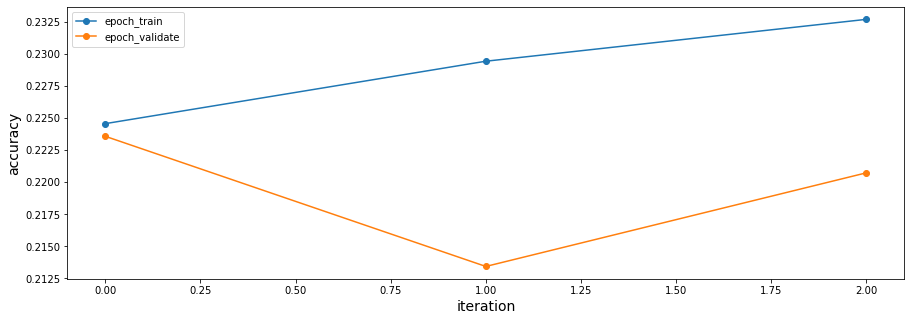

In [11]:
model_name = 'SoftmaxClassifier'

# define the model, optimizer, and scheduler (for lr decay)
model_sm = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names)),
    nn.Softmax(dim=1)
    ).to(device)
optimizer = optim.SGD(model_sm.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=0.1) # lr decay
criterion = nn.NLLLoss()
acc_sm = train_model(model_sm, criterion, optimizer, schedlr,
                             loaders, sizes, device, model_path, num_epochs_baseline)
plot_accs({key: acc_sm[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
if save_mode:
    # MODEL
    torch.save(model_sm.state_dict(), model_path + f'{model_name}.pt')
    # RESULTS
    filename = f'acc_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(acc_sm[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(results_path + filename)

## Hinge loss (SVM)

  0%|                                                   | 0/527 [00:00<?, ?it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:3500: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [32].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755888534/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:3500: UserWarning: An output with one or more elements was resized since it had shape [32], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release o


Returning best model, with validation accuracy 0.19615179048637094


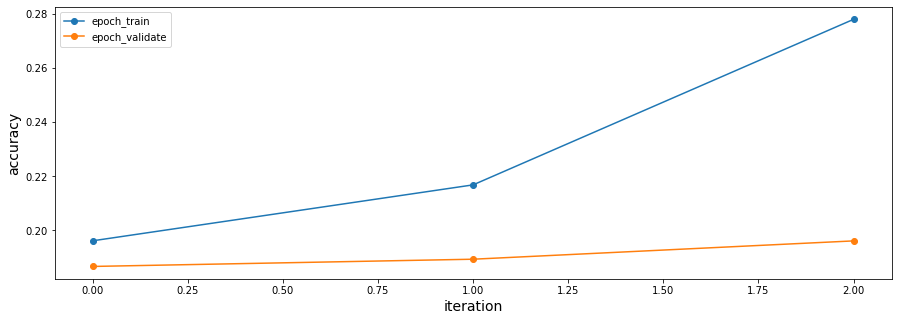

In [12]:
model_name = 'HingeClassifier'

# define model
model_mh = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names))
    ).to(device)
optimizer = optim.SGD(model_mh.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.MultiMarginLoss()
# run model and plot results
acc_mh = train_model(model_mh, criterion, optimizer, schedlr,
                     loaders, sizes, device, model_path, num_epochs_baseline)
plot_accs({key: acc_mh[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
if save_mode:
    # MODEL
    torch.save(model_mh.state_dict(), model_path + f'{model_name}.pt')
    # RESULTS
    filename = f'acc_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(acc_mh[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(results_path + filename)

## 2-layer fully connected net

train epoch: [1/1] Loss: 2.0334 ACC@1: 19.05%: 100%|█| 3/3 [00:16<00:00,  5.45s/i
validate epoch: [1/1] Loss: 3.8804 ACC@1: 12.50%: 100%|█| 1/1 [00:01<00:00,  1.05



Returning best model, with validation accuracy 0.125


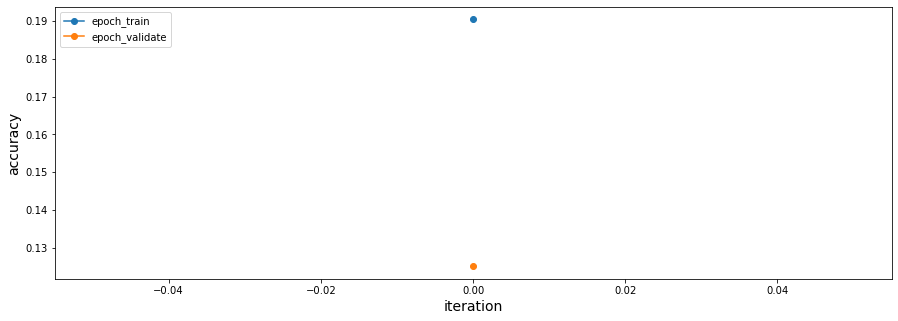

In [19]:
model_name = 'TwoLayerFC'

# define model
hidden_layer_size = 500
model_fc = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, len(class_names))
    ).to(device)
optimizer = optim.SGD(model_fc.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
# run model and plot results
acc_fc = train_model(model_fc, criterion, optimizer, schedlr,
                     loaders, sizes, device, model_path, num_epochs_baseline)
plot_accs({key: acc_fc[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
if save_mode:
    # MODEL
    torch.save(model_fc.state_dict(), model_path + f'{model_name}.pt')
    # RESULTS
    filename = f'acc_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(acc_fc[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(results_path + filename)

## 3-layer ConvNet

train epoch: [1/3] Loss: 1.8416 ACC@1: 26.28%: 100%|█| 527/527 [2:56:09<00:00, 2
validate epoch: [1/3] Loss: 1.7990 ACC@1: 29.25%: 100%|█| 176/176 [58:36<00:00, 
train epoch: [2/3] Loss: 1.7357 ACC@1: 32.82%: 100%|█| 527/527 [2:56:06<00:00, 2
validate epoch: [2/3] Loss: 1.7384 ACC@1: 31.00%: 100%|█| 176/176 [58:32<00:00, 
train epoch: [3/3] Loss: 1.6021 ACC@1: 40.59%: 100%|█| 527/527 [2:56:11<00:00, 2
validate epoch: [3/3] Loss: 1.7297 ACC@1: 32.75%: 100%|█| 176/176 [58:18<00:00, 



Returning best model, with validation accuracy 0.3274541243541778


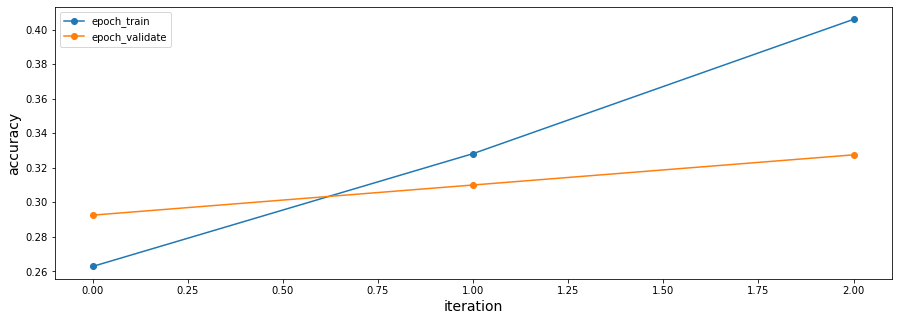

In [13]:
model_name = 'ThreeLayerCNN'

# define model
channel_1 = 32
channel_2 = 16
# padding chosen to preserve original H/W dimensions
model_cn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel_1, kernel_size=5, padding=(5 - 1)//2),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=3, padding=(3 - 1)//2),
    nn.ReLU(), 
    Flatten(),
    nn.Linear(channel_2*IMAGE_DIM*IMAGE_DIM, len(class_names))
    ).to(device)
optimizer_cn = optim.SGD(model_cn.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr_cn = lr_scheduler.StepLR(optimizer_cn, step_size=2, gamma=0.1) # lr decay
criterion_cn = nn.CrossEntropyLoss()
# run model and plot results
acc_cn = train_model(model_cn, criterion_cn, optimizer_cn, schedlr_cn,
                     loaders, sizes, device, model_path, num_epochs_baseline)
plot_accs({key: acc_cn[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
if save_mode:
    # MODEL
    torch.save(model_cn.state_dict(), model_path + f'{model_name}.pt')
    # RESULTS
    filename = f'acc_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(acc_cn[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(results_path + filename)

## Summarize

In [ ]:
key = 'epoch_validate'

baseline_results = {
    'softmax': max(acc_sm[key]),
    'svm': max(acc_mh[key]),
    '2layer_fc': max(acc_fc[key]),
    '3layer_cnn':max(acc_cn[key])
}
baseline_results

# Transfer learning models

## Training only the last fully connected layer

### Resnet

train epoch: [1/6] Loss: 1.8768 ACC@1: 24.76%:  22%|▏| 118/527 [39:55<2:20:49, 2/opt/conda/envs/pytorch/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train epoch: [1/6] Loss: 1.6456 ACC@1: 39.66%: 100%|█| 527/527 [2:52:27<00:00, 1
validate epoch: [1/6] Loss: 1.4112 ACC@1: 49.17%: 100%|█| 176/176 [56:38<00:00, 
train epoch: [2/6] Loss: 1.3315 ACC@1: 52.76%: 100%|█| 527/527 [2:52:20<00:00, 1
validate epoch: [2/6] Loss: 1.2601 ACC@1: 54.39%: 100%|█| 176/176 [56:38<00:00, 
train epoch: [3/6] Loss: 1.2450 ACC@1: 56.28%: 100%|█| 527/527 [2:52:00<00:00, 1
validate epoch: [3/6] Loss: 1.2376 ACC@1: 56.21%: 100%|█| 176/176 [56:54<00:00, 
train epoch: [4/6] Loss: 1.2337 ACC@1: 56.39%: 100%|█| 527/527 [2:50:47<00:00, 1
validate epoch: [4/6] Loss: 1.2197 ACC@1: 55.94%: 100%|█| 176/176 [56:44<00:00, 
train epoch: [5/6] Loss: 1.2245 ACC@1: 57.21%: 100%|█| 527/527 [2:51:02<00:00, 1
vali


Returning best model, with validation accuracy 0.5620880099768395


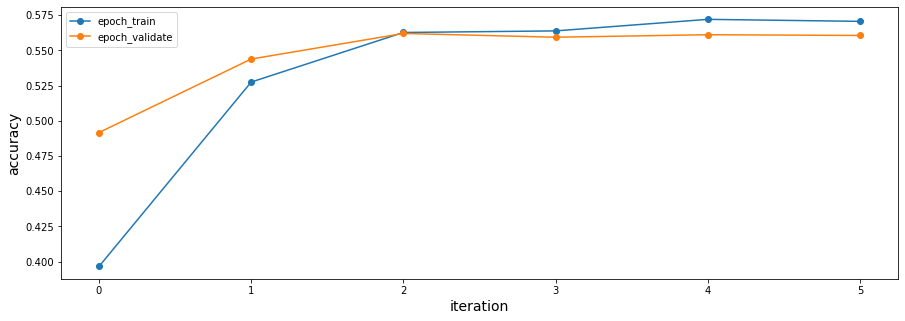

In [8]:
model_name = 'ResnetClassifierFC'

m_resnet = ResnetTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=False)
m_resnet = m_resnet.to(device)
optimizer = optim.SGD(m_resnet.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_res = train_model(m_resnet, criterion, optimizer, schedlr,
                      loaders, sizes, device, model_path, num_epochs)
plot_accs({key: acc_res[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
if save_mode:
    # MODEL
    torch.save(m_resnet.state_dict(), model_path + f'{model_name}.pt')
    # RESULTS
    filename = f'acc_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(acc_res[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(results_path + filename)

### Convnext

train epoch: [1/6] Loss: 1.8740 ACC@1: 29.00%:  22%|▏| 118/527 [39:38<2:18:53, 2/opt/conda/envs/pytorch/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train epoch: [1/6] Loss: 1.6191 ACC@1: 42.77%: 100%|█| 527/527 [2:53:47<00:00, 1
validate epoch: [1/6] Loss: 1.3352 ACC@1: 52.34%: 100%|█| 176/176 [57:15<00:00, 
train epoch: [2/6] Loss: 1.2251 ACC@1: 56.39%: 100%|█| 527/527 [2:54:13<00:00, 1
validate epoch: [2/6] Loss: 1.1332 ACC@1: 60.40%: 100%|█| 176/176 [57:22<00:00, 
train epoch: [3/6] Loss: 1.1214 ACC@1: 60.73%: 100%|█| 527/527 [2:51:59<00:00, 1
validate epoch: [3/6] Loss: 1.1113 ACC@1: 60.63%: 100%|█| 176/176 [56:50<00:00, 
train epoch: [4/6] Loss: 1.1121 ACC@1: 61.43%: 100%|█| 527/527 [2:53:58<00:00, 1
validate epoch: [4/6] Loss: 1.0988 ACC@1: 61.48%: 100%|█| 176/176 [57:10<00:00, 
train epoch: [5/6] Loss: 1.1021 ACC@1: 61.80%: 100%|█| 527/527 [2:53:20<00:00, 1
vali


Returning best model, with validation accuracy 0.6148227329413861


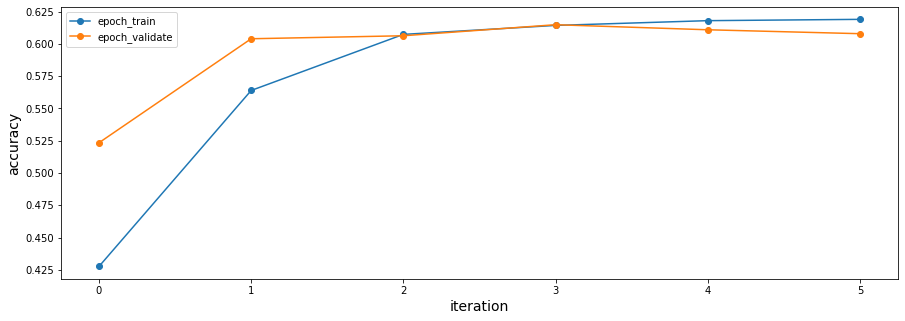

In [10]:
model_name = 'ConvNextClassifierFC'

m_convnext = ConvnextTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=False)
m_convnext = m_convnext.to(device)
optimizer = optim.SGD(m_convnext.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_convnext = train_model(m_convnext, criterion, optimizer, schedlr,
                           loaders, sizes, device, model_path, num_epochs)
plot_accs({key: acc_convnext[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
if save_mode:
    # MODEL
    torch.save(m_convnext.state_dict(), model_path + f'{model_name}.pt')
    # RESULTS
    filename = f'acc_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(acc_convnext[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(results_path + filename)

### Transformer

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

train epoch: [1/1] Loss: 9.0198 ACC@1: 0.00%: 100%|█| 3/3 [00:15<00:00,  5.30s/it
validate epoch: [1/1] Loss: 8.6853 ACC@1: 0.00%: 100%|█| 1/1 [00:01<00:00,  1.09s


Returning best model, with validation accuracy 0.0


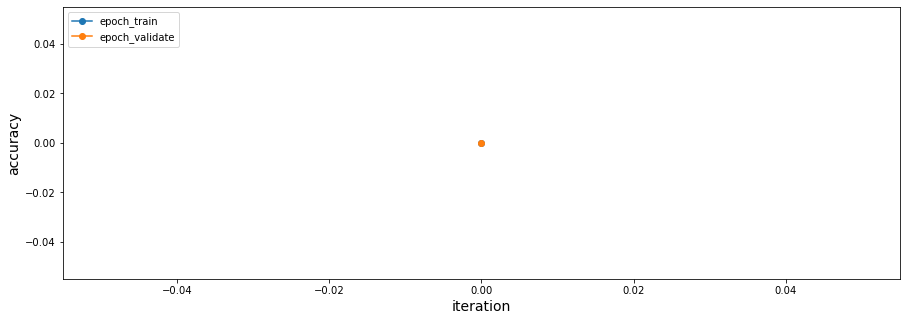

In [18]:
model_name = 'TransformerClassifierFC'

m_trans = TransformerTransferClassifier(num_classes=len(class_names), retrain_last_encoder=False)
m_trans = m_trans.to(device)
optimizer = optim.SGD(m_trans.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_trans = train_model(m_trans, criterion, optimizer, schedlr,
                        loaders, sizes, device, model_path, num_epochs)
plot_accs({key: acc_trans[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
if save_mode:
    # MODEL
    torch.save(m_trans.state_dict(), model_path + f'{model_name}.pt')
    # RESULTS
    filename = f'acc_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(acc_trans[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(results_path + filename)

## Convnext classifier one extra layer

In [ ]:
model_name = 'ConvNextClassifierOneLayer'

m_convnext_d = ConvnextTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=True)
m_convnext_d = m_convnext_d.to(device)
optimizer = optim.SGD(m_convnext_d.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_convnext_d = train_model(m_convnext_d, criterion, optimizer, schedlr,
                           loaders, sizes, device, model_path, num_epochs)
plot_accs({key: acc_convnext_d[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
if save_mode:
    # MODEL
    torch.save(m_convnext_d.state_dict(), model_path + f'{model_name}.pt')
    # RESULTS
    filename = f'acc_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(acc_convnext_d[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(results_path + filename)

### Resnet classifier one extra layer

In [ ]:
## Resnet Classifier one extra layer
model_name = 'ResnetClassifierOneLayer'

m_resnet_d = ResnetTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=True)
m_resnet_d = m_resnet_d.to(device)
optimizer = optim.SGD(m_resnet_d.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_resnet_d = train_model(m_resnet_d, criterion, optimizer, schedlr,
                           loaders, sizes, device, model_path, num_epochs)
plot_accs({key: acc_resnet_d[key] for key in ['epoch_train', 'epoch_validate']})
# save to file
if save_mode:
    # MODEL
    torch.save(m_resnet_d.state_dict(), model_path + f'{model_name}.pt')
    # RESULTS
    filename = f'acc_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(acc_resnet_d[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(results_path + filename)

### Summarize transfer learning of last fully-connected layer

In [22]:
key = 'epoch_validate'
transfer_resultsfc = {
    'resnetfc': max(acc_res[key]),
    'resnet': max(acc_res_d[key]),
    'convnextfc': max(acc_convnext[key]),
    'convnext': max(acc_convnext_d[k]),
    'transformerfc':max(acc_trans[key])
}
transfer_resultsfc

{'resnetfc': tensor(0.2500, dtype=torch.float64),
 'convnextfc': tensor(0.1250, dtype=torch.float64),
 'transformerfc': tensor(0., dtype=torch.float64)}